# Exploratory Data Analysis of Brain Tumor MRI Dataset

In [ ]:
!pip install hdf5storage opencv-python

In [ ]:
import os
import hdf5storage
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from tqdm import tqdm
import cv2
import shutil
import glob
import random
from PIL import Image

# Imports for model development
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, utils, datasets
# import torchinfo
import torchvision
# from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip freeze > requirements.txt

### Download & Extract the Dataset

In [ ]:
#Create directory
!mkdir -p brain_tumor_dataset
%cd brain_tumor_dataset

#Download dataset
!wget https://ndownloader.figshare.com/articles/1512427/versions/5 -O part.zip

#Unzip file and move mat files to data folder
!unzip part.zip && rm part.zip
!cat brainTumorDataPublic_* > brainTumorDataPublic_temp.zip
!zip -FF brainTumorDataPublic_temp.zip --out data.zip
!rm brainTumorDataPublic_*
!unzip data.zip -d data && rm data.zip


In [ ]:
# Check for number of scan images
len(os.listdir('data'))

3064

### Loading an Image

In [ ]:
# Path to dataset folder
DATA_DIR = '/content/brain_tumor_dataset/data'

# Pick a sample .mat file
sample_file = os.path.join(DATA_DIR, os.listdir(DATA_DIR)[0])  # First file

# Load the .mat file
data = hdf5storage.loadmat(sample_file)['cjdata']



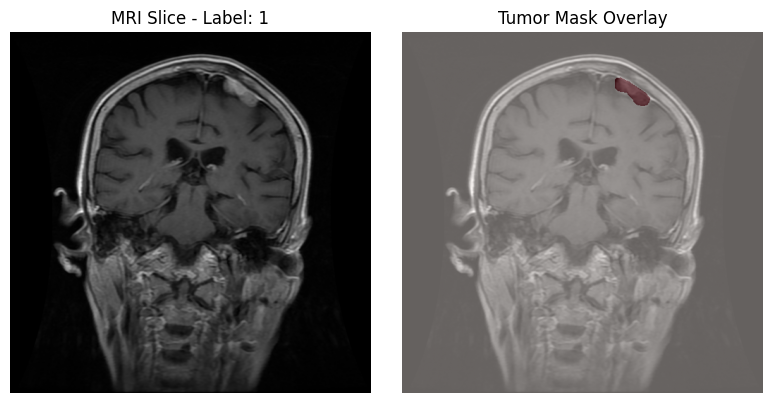

In [ ]:
# Extract the MRI scan and the tumor mask
image = np.squeeze(data['image'])
tumor_mask = np.squeeze(data['tumorMask'])
label = int(np.squeeze(data['label']))


plt.figure(figsize=(8, 4))

# Original MRI image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title(f'MRI Slice - Label: {label}')
plt.axis('off')

# MRI with tumor overlay
plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray')
plt.imshow(tumor_mask, cmap='Reds', alpha=0.4)
plt.title('Tumor Mask Overlay')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Set paths and label map
labels_map = {1: "Meningioma", 2: "Glioma", 3: "Pituitary"}

# Lists to store data
records = []
mask_shape = []
# Read and parse all files
mat_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.mat')]

for file in mat_files:
    path = os.path.join(DATA_DIR, file)
    data = hdf5storage.loadmat(path)['cjdata']

    label = int(np.squeeze(data['label']))
    tumor_mask = np.squeeze(data['tumorMask'])
    mask_shape.append(tumor_mask.shape)
    pid = str(np.squeeze(data['PID']))  # patient ID
    tumor_area = int(np.sum(tumor_mask))

    records.append({
        'file_name': file,
        'label': label,
        'label_name': labels_map[label],
        'patient_id': pid,
        'tumor_area': tumor_area
    })

# Create DataFrame
df = pd.DataFrame(records)
df.head()

,file_name,label,label_name,patient_id,tumor_area
0,284.mat,1,Meningioma,105555,980
1,1053.mat,3,Pituitary,107429,3494
2,832.mat,2,Glioma,101020,4296
3,2043.mat,2,Glioma,MR051796,4514
4,620.mat,1,Meningioma,112650,3187


In [ ]:
# Number of images per class
df['label_name'].value_counts()

,count
label_name,
Glioma,1426
Pituitary,930
Meningioma,708


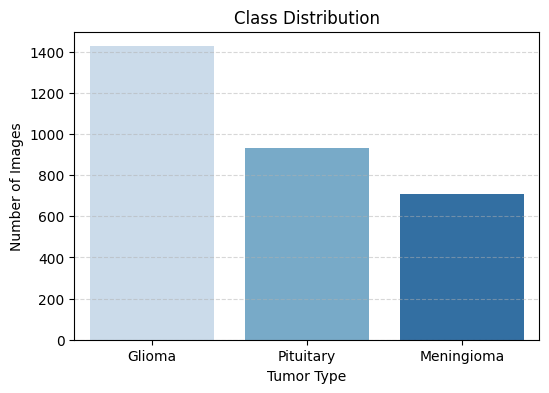

In [ ]:
# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label_name', order=df['label_name'].value_counts().index, palette='Blues', legend=False)
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Tumor Type")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

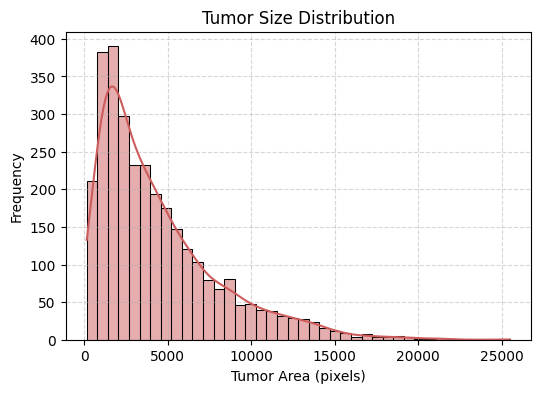

In [ ]:
#Tumor size distribution
plt.figure(figsize=(6,4))
sns.histplot(df['tumor_area'], bins=40, kde=True, color='indianred')
plt.title("Tumor Size Distribution")
plt.xlabel("Tumor Area (pixels)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

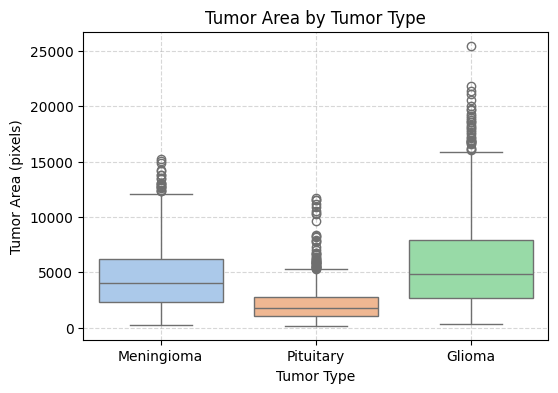

In [ ]:
# Investigating the avaerage sizes of Tumor types
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='label_name', y='tumor_area', palette='pastel')
plt.title("Tumor Area by Tumor Type")
plt.ylabel("Tumor Area (pixels)")
plt.xlabel("Tumor Type")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

- **Gliomas** show the largest size variation, with many large tumors and extreme outliers.
This variability may make them harder to classify, requiring the model to handle wide size differences.

- **Pituitary** tumors are consistently small, with low variance in size.
These could be sensitive to cropping or resizing, possibly making them harder for the model to detect.

- **Meningiomas** fall in the mid-range for tumor area, with moderate variance.
Their size and consistency may make them easier for the model to detect and classify accurately.



In [ ]:
df['patient_id']

,patient_id
0,105555
1,107429
2,101020
3,MR051796
4,112650
...,...
3059,MR026175E
3060,98241
3061,109898
3062,101016


In [ ]:
df['patient_id']

,patient_id
0,105555
1,107429
2,101020
3,MR051796
4,112650
...,...
3059,MR026175E
3060,98241
3061,109898
3062,101016


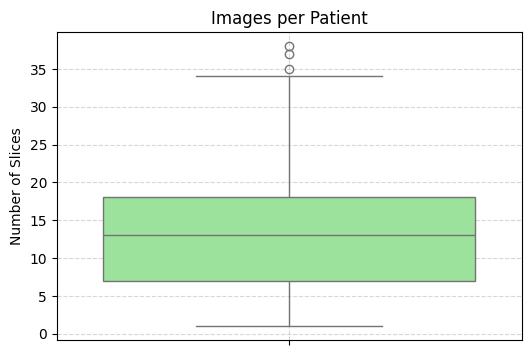

In [ ]:
# Image count per patient
img_per_patient = df.groupby('patient_id')['label'].count()

plt.figure(figsize=(6,4))
sns.boxplot(y=img_per_patient.values, color='lightgreen')
plt.title("Images per Patient")
plt.ylabel("Number of Slices")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

On average, each patient has around **13 MRI slices**.
- The number of slices varies significantly across patients, with some having as few as 1, and others over 30.
- This suggests the need to ensure that data is **split by patient**, not by individual slices, to avoid data leakage.
- The variation in slice count may also affect model training, especially if some classes (tumor types) are overrepresented due to more slices per patient.

## View Images for each class

In [ ]:
labels_map

{1: 'Meningioma', 2: 'Glioma', 3: 'Pituitary'}

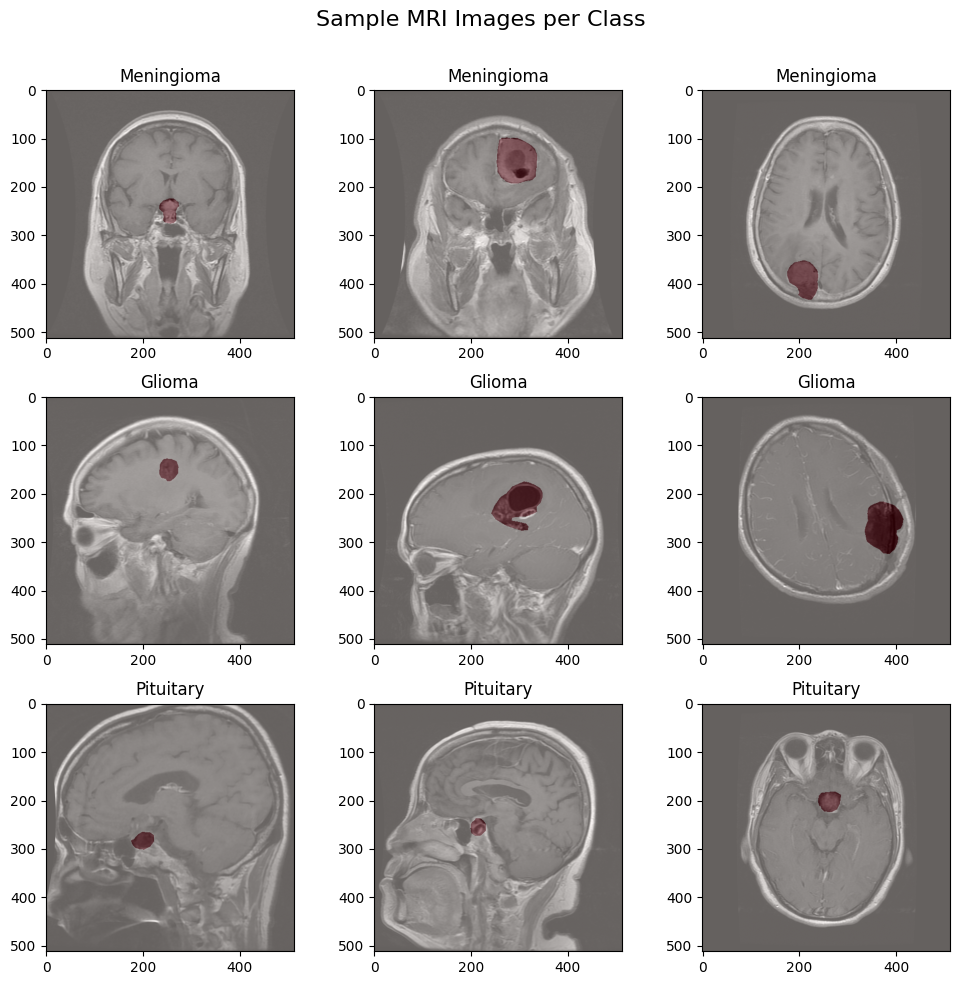

In [ ]:
#Image gallery per tumor class
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("Sample MRI Images per Class", fontsize=16)

for i, (label, label_name) in enumerate(labels_map.items()):
    sample_files = df[df['label'] == label].sample(3, random_state=42)['file_name'].values
    # print(f"{label_name}: {len(sample_files)}")

    # print(list(enumerate(sample_files)))
    for j, filename in enumerate(sample_files):
        data = hdf5storage.loadmat(os.path.join(DATA_DIR, filename))['cjdata']
        image = np.squeeze(data['image'])
        tumor_mask = np.squeeze(data['tumorMask'])

        ax = axes[i][j]
        ax.imshow(image, cmap='gray')
        ax.imshow(tumor_mask, cmap='Reds', alpha=0.4)
        ax.set_title(f"{label_name}")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Data Preprocessing

Results from the `image per patients count` vizualization shows that we have an average of 13 scan images per patient. This means that to prevent data leakage in our model, we need to split the dataset by the unique patients into train,  val and test sets while ensuring that we maintain the difference in class items in each set by .

In [ ]:
# Getting unique patients
unique_group_df = df[['patient_id', 'label']].drop_duplicates()
print(f"Number of unique patients: {len(unique_group_df)}")

# Spliting the dataset to train
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])


Number of unique patients: 233


In [ ]:
# Get the average number of scans each patients has
df.groupby('patient_id')['file_name'].count().mean()

np.float64(13.150214592274677)

In [ ]:
# Group by patient_id and count unique file_names (scans)
scan_counts = df.groupby('patient_id')['label_name'].nunique().reset_index()
scan_counts.columns = ['patient_id','num_scans']

# Display a sample
scan_counts.sort_values('num_scans', ascending=False).head()

,patient_id,num_scans
0,100360,1
1,100416,1
2,100572,1
3,100639,1
4,100820,1


In [ ]:
# Investigating to see if there are patients that have scans for more than one tumor type
inconsistent_scans = scan_counts[scan_counts['num_scans'] != 1]
inconsistent_scans

,patient_id,num_scans


The empty `inconsistent_scans` dataframe above shows that even though there is an average of 13 MRI scans per patient, no patient has scans for more than one tumor type.

In [ ]:
df[['patient_id', 'label']].value_counts().head()

,,count
patient_id,label,
MR032322C,2,38
MR051644,2,37
MR051644C,2,35
MR050135B,2,34
MR040240C,2,31


In [ ]:
def stratified_group_split(df, group_col, stratify_col, test_size=0.2, val_size=0.1, random_state=42):
    """Splits dataset so that a single patient's data does not appear in more than one set and also preserve class balance across splits

    Args:
        df: pandas DataFrame
        group_col: column name for grouping (e.g., patient_id)
        stratify_col: column name for stratification (e.g., label_name)
        test_size: proportion of data to assign to test set
        val_size: proportion of data to assign to validation set (out of total data)
        random_state: random seed for reproducibility

    Returns:
        train_df, val_df, test_df
    """
    # Create a group-level dataframe
    group_df = df[[group_col, stratify_col]].drop_duplicates()

    # Spliting into train+val and test groups
    train_val_groups, test_groups = train_test_split(group_df, test_size=test_size, stratify=group_df[stratify_col], random_state=random_state)

    # spliting train+val into train and val groups
    val_ratio = val_size / (1 - test_size)  # adjust val proportion relative to train+val total

    train_groups, val_groups = train_test_split(train_val_groups, test_size=val_ratio, stratify=train_val_groups[stratify_col], random_state=random_state)

    # Get full dataframes based on group membership
    train_df = df[df[group_col].isin(train_groups[group_col])]
    val_df   = df[df[group_col].isin(val_groups[group_col])]
    test_df  = df[df[group_col].isin(test_groups[group_col])]

    return train_df, val_df, test_df


In [ ]:
train_df, val_df, test_df = stratified_group_split(df, 'patient_id', 'label')

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((2114, 5), (327, 5), (623, 5))

In [ ]:
train_patients = train_df['patient_id'].unique()
val_patients = val_df['patient_id'].unique()
test_patients = test_df['patient_id'].unique()

### Data Split & Conversion

This `move_images` function takes a list of patient IDs and:

- Loads their .mat MRI scan files

- Converts grayscale images to RGB

- Saves them as .jpg images

- Organizes them into structured folders by split and tumor label

This prepares the dataset for CNN training using standard image folders.

In [ ]:
SOURCE_DIR = '/content/brain_tumor_dataset/data'
DEST_DIR = '/content/brain_tumor_dataset/data_split'

def move_images(df, patient_list, split_name):

    for _, row in tqdm(df[df['patient_id'].isin(patient_list)].iterrows(),
                       total=len(df[df['patient_id'].isin(patient_list)])):
        label = row['label_name']
        file_name = row['file_name']
        file_stem = os.path.splitext(file_name)[0]

        # Load .mat file
        src_path = os.path.join(SOURCE_DIR, file_name)
        try:
            data = hdf5storage.loadmat(src_path)['cjdata']
            image = np.squeeze(data['image']).astype(np.uint8)

            # Convert to PIL and RGB
            if image.ndim == 2:
                pil_img = Image.fromarray(image).convert('RGB')
            elif image.ndim == 3 and image.shape[2] == 1:
                pil_img = Image.fromarray(image.squeeze(-1)).convert('RGB')
            else:
                pil_img = Image.fromarray(image).convert('RGB')

            # Create destination directory
            dest_dir = os.path.join(DEST_DIR, split_name, label)
            os.makedirs(dest_dir, exist_ok=True)

            # Save as .jpg
            dest_path = os.path.join(dest_dir, f"{file_stem}.jpg")
            pil_img.save(dest_path)

        except Exception as e:
            print(f"Failed to process {file_name}: {e}")


In [ ]:
# Calling the `move_images` on the different splits
move_images(df, train_patients, "train")
move_images(df, val_patients, "val")
move_images(df, test_patients, "test")

100%|██████████| 623/623 [00:09<00:00, 68.77it/s]


In [ ]:
# Just to check the number of images in each class on the train splits
print(len(os.listdir('/content/brain_tumor_dataset/data_split/train/Meningioma')))
print(len(os.listdir('/content/brain_tumor_dataset/data_split/train/Glioma')))
print(len(os.listdir('/content/brain_tumor_dataset/data_split/train/Pituitary')))

516
988
610


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [ ]:
class AlbumentationsTransform:
    def __init__(self, augmentations):
        self.augment = augmentations

    def __call__(self, image):
        if not isinstance(image, np.ndarray):
            image = np.array(image)  # convert PIL to NumPy

        augmented = self.augment(image=image)
        image_tensor = augmented['image']
        return image_tensor.float()  # ensure float32

In [ ]:
# Define transformers
train_transforms = AlbumentationsTransform(A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
]))

val_transforms = AlbumentationsTransform(A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
]))

In [ ]:
train_dir = "/content/brain_tumor_dataset/data_split/train"
val_dir = "/content/brain_tumor_dataset/data_split/val"
test_dir = "/content/brain_tumor_dataset/data_split/test"

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
for images, labels in train_loader:
    print(images.dtype)   # should be torch.float32
    print(images.shape)   # should be [B, 3, 512, 512]
    break

torch.float32
torch.Size([32, 3, 512, 512])


In [ ]:
class TumorClassifierCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(TumorClassifierCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (B, 3, 512, 512) → (B, 32, 512, 512)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → (B, 32, 256, 256)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → (B, 64, 128, 128)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → (B, 128, 64, 64)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 64 * 64, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x

In [ ]:

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4, device='cuda'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        all_preds, all_labels = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {running_loss:.3f} | Train Acc: {acc:.4f}")

        evaluate_model(model, val_loader, device=device)

In [ ]:
def evaluate_model(model, dataloader, device='cuda'):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Glioma', 'Meningioma', 'Pituitary']))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Glioma', 'Meningioma', 'Pituitary'],
                yticklabels=['Glioma', 'Meningioma', 'Pituitary'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
2* (0.79 * 0.81)/ (0.79 + 0.81)

0.799875

Epoch 1/10 | Train Loss: 294.890 | Train Acc: 0.5492
Classification Report:
              precision    recall  f1-score   support

      Glioma       0.71      0.93      0.81       150
  Meningioma       0.46      0.35      0.40        60
   Pituitary       0.90      0.65      0.76       117

    accuracy                           0.72       327
   macro avg       0.69      0.64      0.65       327
weighted avg       0.73      0.72      0.71       327



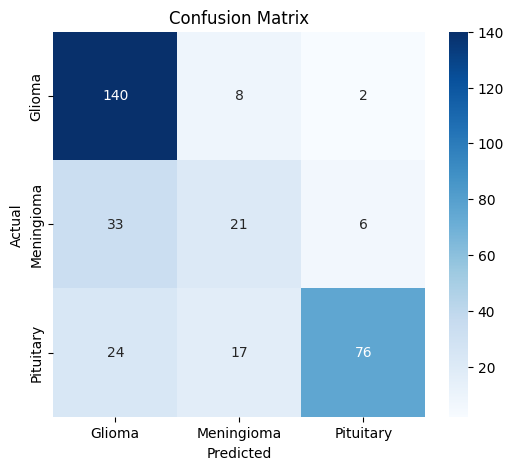

Epoch 2/10 | Train Loss: 52.587 | Train Acc: 0.6258
Classification Report:
              precision    recall  f1-score   support

      Glioma       0.62      0.71      0.66       150
  Meningioma       0.34      0.42      0.37        60
   Pituitary       0.96      0.67      0.79       117

    accuracy                           0.64       327
   macro avg       0.64      0.60      0.61       327
weighted avg       0.69      0.64      0.66       327



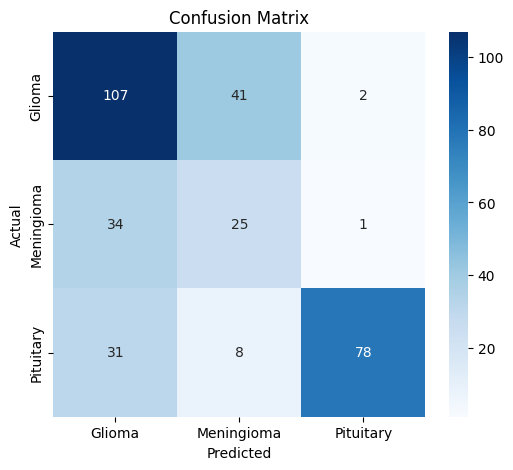

Epoch 3/10 | Train Loss: 51.411 | Train Acc: 0.6079
Classification Report:
              precision    recall  f1-score   support

      Glioma       0.70      0.96      0.81       150
  Meningioma       0.68      0.25      0.37        60
   Pituitary       0.91      0.78      0.84       117

    accuracy                           0.76       327
   macro avg       0.76      0.66      0.67       327
weighted avg       0.77      0.76      0.74       327



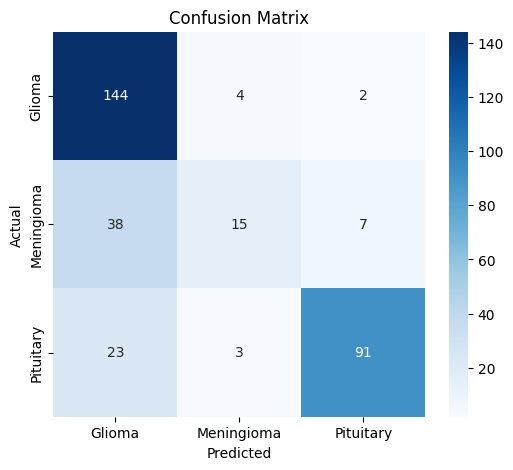

Epoch 4/10 | Train Loss: 52.123 | Train Acc: 0.6225
Classification Report:
              precision    recall  f1-score   support

      Glioma       0.76      0.97      0.85       150
  Meningioma       0.86      0.20      0.32        60
   Pituitary       0.85      0.89      0.87       117

    accuracy                           0.80       327
   macro avg       0.82      0.69      0.68       327
weighted avg       0.81      0.80      0.76       327



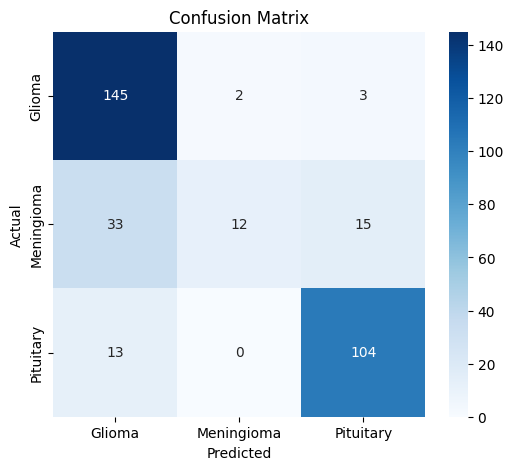

Epoch 5/10 | Train Loss: 49.700 | Train Acc: 0.6301
Classification Report:
              precision    recall  f1-score   support

      Glioma       0.82      0.75      0.78       150
  Meningioma       0.44      0.53      0.48        60
   Pituitary       0.88      0.89      0.89       117

    accuracy                           0.76       327
   macro avg       0.71      0.72      0.72       327
weighted avg       0.77      0.76      0.76       327



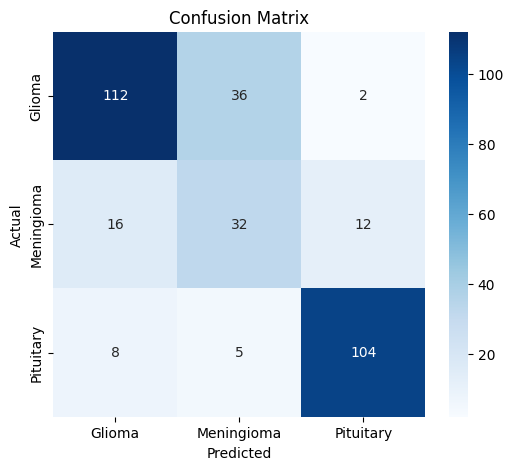

Epoch 6/10 | Train Loss: 45.057 | Train Acc: 0.6627
Classification Report:
              precision    recall  f1-score   support

      Glioma       0.83      0.82      0.82       150
  Meningioma       0.50      0.45      0.47        60
   Pituitary       0.89      0.94      0.91       117

    accuracy                           0.80       327
   macro avg       0.74      0.74      0.74       327
weighted avg       0.79      0.80      0.79       327



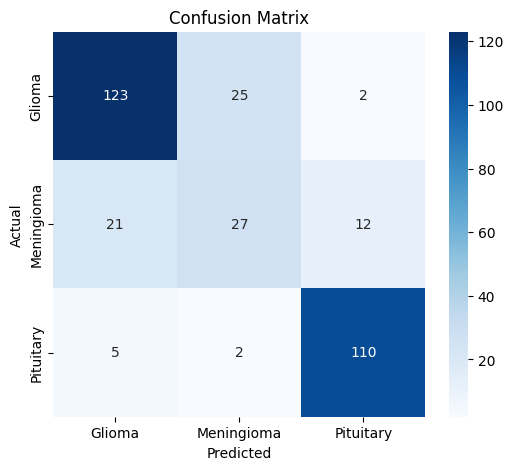

Epoch 7/10 | Train Loss: 42.814 | Train Acc: 0.6911
Classification Report:
              precision    recall  f1-score   support

      Glioma       1.00      0.68      0.81       150
  Meningioma       0.48      0.78      0.59        60
   Pituitary       0.88      0.96      0.92       117

    accuracy                           0.80       327
   macro avg       0.79      0.81      0.77       327
weighted avg       0.86      0.80      0.81       327



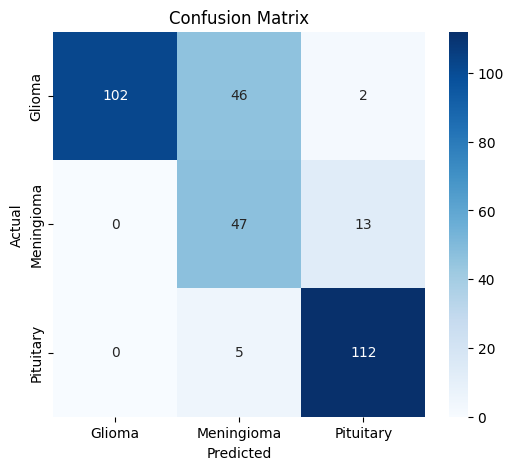

Epoch 8/10 | Train Loss: 45.716 | Train Acc: 0.6604
Classification Report:
              precision    recall  f1-score   support

      Glioma       1.00      0.72      0.84       150
  Meningioma       0.50      0.82      0.62        60
   Pituitary       0.89      0.92      0.91       117

    accuracy                           0.81       327
   macro avg       0.80      0.82      0.79       327
weighted avg       0.87      0.81      0.82       327



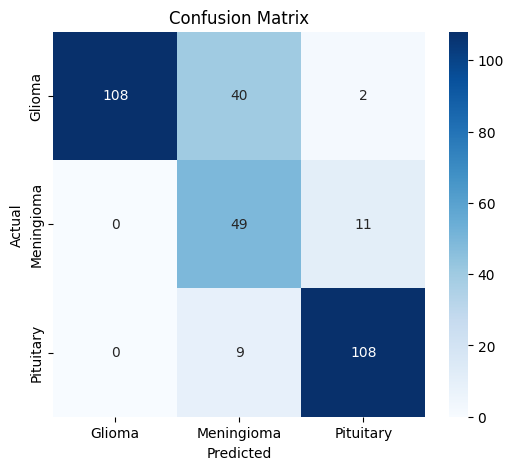

Epoch 9/10 | Train Loss: 40.816 | Train Acc: 0.7081
Classification Report:
              precision    recall  f1-score   support

      Glioma       0.93      0.75      0.83       150
  Meningioma       0.52      0.62      0.56        60
   Pituitary       0.85      0.97      0.91       117

    accuracy                           0.81       327
   macro avg       0.77      0.78      0.77       327
weighted avg       0.82      0.81      0.81       327



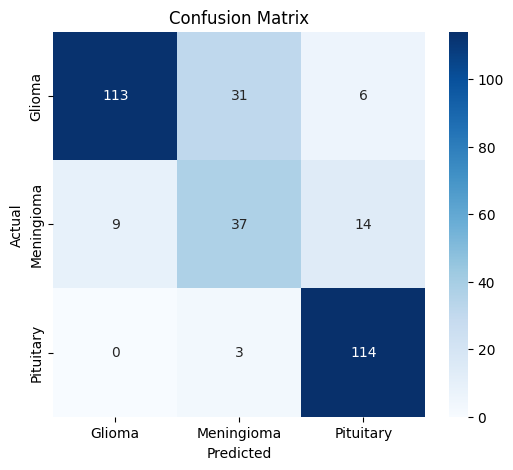

Epoch 10/10 | Train Loss: 36.524 | Train Acc: 0.7219
Classification Report:
              precision    recall  f1-score   support

      Glioma       0.92      0.74      0.82       150
  Meningioma       0.52      0.62      0.56        60
   Pituitary       0.84      0.97      0.90       117

    accuracy                           0.80       327
   macro avg       0.76      0.78      0.76       327
weighted avg       0.82      0.80      0.80       327



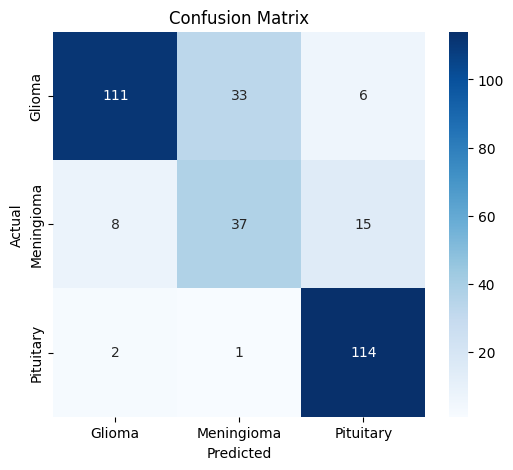

In [ ]:
model = TumorClassifierCNN(num_classes=3)
train_model(model, train_loader, val_loader, epochs=10, lr=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu')


### Evaluation Summary (Baseline CNN)
The model trained well but showed bias toward the majority classes. `Glioma` and `Pituitary` were predicted accurately, while `Meningioma` (the minority class) was often misclassified. The confusion matrix confirms this imbalance.

Overall accuracy was decent, but per-class metrics showed the need for data balancing to improve fairness and generalization across all tumor types.

# Balancing the datasets

In [ ]:
def balance_and_augment_from_jpg(
    source_dir, dest_dir, transform=None, seed=42
):
    """
    Balances and optionally augments class folders in `source_dir`.
    Saves balanced result to `dest_dir`.

    Args:
        source_dir (str): Path to original split (train/val/test).
        dest_dir (str): Path to output balanced version.
        transform (AlbumentationsTransform): Transform to apply during augmentation.
    """
    os.makedirs(dest_dir, exist_ok=True)
    random.seed(seed)

    class_image_paths = {}
    class_counts = {}

    # Step 1: Load all image paths and class names
    for class_name in os.listdir(source_dir):
        src_class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(src_class_path):
            continue

        images = [os.path.join(src_class_path, f) for f in os.listdir(src_class_path)
                  if f.lower().endswith(('.jpg', '.png'))]
        class_image_paths[class_name] = images
        class_counts[class_name] = len(images)

    print(f"\n📂 Balancing: {source_dir}")
    print("Original class distribution:", class_counts)
    max_count = max(class_counts.values())

    # Step 2: Create class folders in destination
    for class_name in class_image_paths:
        os.makedirs(os.path.join(dest_dir, class_name), exist_ok=True)

    # Step 3: Copy originals and augment if needed
    for class_name, image_paths in class_image_paths.items():
        dest_class_path = os.path.join(dest_dir, class_name)

        # Copy originals
        for i, img_path in enumerate(image_paths):
            img = cv2.imread(img_path)
            if img is not None:
                save_path = os.path.join(dest_class_path, f"orig_{i}.jpg")
                cv2.imwrite(save_path, img)

        # Augment if needed
        samples_needed = max_count - len(image_paths)
        if samples_needed > 0 and transform:
            print(f"🧪 Augmenting {samples_needed} images for class '{class_name}'")
            for i in tqdm(range(samples_needed)):
                src_img_path = random.choice(image_paths)
                img = cv2.imread(src_img_path)

                if img is None:
                    continue

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                augmented = transform(image=img)
                aug_img = augmented.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
                aug_img_bgr = cv2.cvtColor(aug_img.astype(np.uint8), cv2.COLOR_RGB2BGR)

                save_path = os.path.join(dest_class_path, f"aug_{i+len(image_paths)}.jpg")
                cv2.imwrite(save_path, aug_img_bgr)


In [ ]:
# Paths
base_path = "/content/brain_tumor_dataset/data_split"

balance_and_augment_from_jpg(
    source_dir=os.path.join(base_path, "train"),
    dest_dir=os.path.join(base_path, "balanced_train"),
    transform=train_transforms
)



📂 Balancing: /content/brain_tumor_dataset/data_split/train
Original class distribution: {'Meningioma': 516, 'Glioma': 988, 'Pituitary': 610}
🧪 Augmenting 472 images for class 'Meningioma'


100%|██████████| 472/472 [00:04<00:00, 107.05it/s]


🧪 Augmenting 378 images for class 'Pituitary'


100%|██████████| 378/378 [00:03<00:00, 116.91it/s]


In [ ]:
len(os.listdir("/content/brain_tumor_dataset/data_split/balanced_train/Pituitary"))

988

In [ ]:
len(os.listdir("/content/brain_tumor_dataset/data_split/balanced_train/Meningioma"))

988